<a href="https://colab.research.google.com/github/sriieeu/Low-Light-Image-Enhancement/blob/main/dark2light.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose, Resize, Normalize
from os.path import join
from torchvision.models import vgg16
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch

class LoLDataset(Dataset):
    def __init__(self, low_light_dir, well_lit_dir, transform=None):
        self.low_light_dir = low_light_dir
        self.well_lit_dir = well_lit_dir
        self.transform = transform
        self.image_pairs = []

        # Collect pairs of low-light and well-lit images
        for root, _, files in os.walk(low_light_dir):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.png'):
                    input_path = os.path.join(root, file)
                    target_path = os.path.join(well_lit_dir, file)  # Directly use same file name
                    if os.path.exists(target_path):
                        self.image_pairs.append((input_path, target_path))

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        input_path, target_path = self.image_pairs[idx]
        try:
            input_image = Image.open(input_path).convert('RGB')
            target_image = Image.open(target_path).convert('RGB')
        except:
            print(f"Error opening images: {input_path}, {target_path}")
            return None, None

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image


# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


low_light_dir = "/content/drive/MyDrive/lol_dataset/our485/low"
well_lit_dir = "/content/drive/MyDrive/lol_dataset/our485/high"


# Check if the directories exist
if not os.path.exists(low_light_dir):
    print(f"The directory {low_light_dir} does not exist.")
if not os.path.exists(well_lit_dir):
    print(f"The directory {well_lit_dir} does not exist.")

dataset = LoLDataset(low_light_dir, well_lit_dir, transform=transform)

# Check if dataset is not empty
if len(dataset) > 0:
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    batch_size = 32
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
else:
    print("The dataset is empty. Please check the provided directories.")
    train_loader = None
    val_loader = None


In [5]:
import random

if len(dataset) > 0:
    # Print sample pairs of loaded images
    sample_pairs = random.sample(dataset.image_pairs, k=5)  # Change the value of k to the desired number of sample pairs
    for input_path, target_path in sample_pairs:
        print(f"Input Image: {input_path}")
        print(f"Target Image: {target_path}")
        print()
else:
    print("Dataset does not have any images.")


Input Image: /content/drive/MyDrive/lol_dataset/our485/low/609.png
Target Image: /content/drive/MyDrive/lol_dataset/our485/high/609.png

Input Image: /content/drive/MyDrive/lol_dataset/our485/low/561.png
Target Image: /content/drive/MyDrive/lol_dataset/our485/high/561.png

Input Image: /content/drive/MyDrive/lol_dataset/our485/low/567.png
Target Image: /content/drive/MyDrive/lol_dataset/our485/high/567.png

Input Image: /content/drive/MyDrive/lol_dataset/our485/low/495.png
Target Image: /content/drive/MyDrive/lol_dataset/our485/high/495.png

Input Image: /content/drive/MyDrive/lol_dataset/our485/low/244.png
Target Image: /content/drive/MyDrive/lol_dataset/our485/high/244.png



In [6]:
import torchvision.transforms as transforms

# Define the generator architecture
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define the discriminator architecture
class Discriminator(nn.Module):
    def __init__(self, in_channels=6):
        super(Discriminator, self).__init__()

        # Modification: Add more layers to increase model capacity
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        input = torch.cat([x, y], dim=1)
        return self.model(input)

In [7]:
# Initialize the generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Move models to GPU if available
# Set device to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move models to the device
generator = generator.to(device)
discriminator = discriminator.to(device)

# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)
else:
    print("Using a single GPU or CPU")
# Loss functions
adversarial_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# Learning rates
lr = 0.0001

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Number of epochs
num_epochs = 300

# Lambda for L1 loss
lambda_l1 = 100

class PairedImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_names = os.listdir(join(root_dir, 'low'))

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = self.file_names[idx]
        low_image = Image.open(join(self.root_dir, 'low', img_name))
        high_image = Image.open(join(self.root_dir, 'high', img_name))

        if self.transform:
            low_image = self.transform(low_image)
            high_image = self.transform(high_image)

        return low_image, high_image

# Data loaders
transform = Compose([Resize((256, 256)), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = PairedImageFolder('/content/drive/MyDrive/lol_dataset/our485/', transform=transform)
val_dataset = PairedImageFolder('/content/drive/MyDrive/lol_dataset/eval15', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Using a single GPU or CPU


In [12]:
ssim_values = []
epoch_numbers = []

# Training loop
for epoch in range(num_epochs):
    for input_images, target_images in train_loader:
        input_images = input_images.to(device)
        target_images = target_images.to(device)

        # Train the discriminator
        d_optimizer.zero_grad()

        # Generate fake images
        fake_images = generator(input_images)

        # Compute discriminator loss on real and fake images
        real_output = discriminator(input_images, target_images)
        fake_output = discriminator(input_images, fake_images.detach())

        real_loss = adversarial_loss(real_output, torch.ones_like(real_output))
        fake_loss = adversarial_loss(fake_output, torch.zeros_like(fake_output))
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        d_optimizer.step()

        # Train the generator
        g_optimizer.zero_grad()

        # Generate fake images
        fake_images = generator(input_images)

        # Compute generator loss
        fake_output = discriminator(input_images, fake_images)
        g_adversarial_loss = adversarial_loss(fake_output, torch.ones_like(fake_output))
        g_l1_loss = l1_loss(fake_images, target_images)
        g_loss = g_adversarial_loss + lambda_l1 * g_l1_loss

        g_loss.backward()
        g_optimizer.step()

    # Evaluate on the validation set
    generator.eval()
    discriminator.eval()
    val_ssim_scores = []
    val_psnr_scores = []

    for input_images, target_images in val_loader:
        input_images = input_images.to(device)
        target_images = target_images.to(device)

        with torch.no_grad():
            generated_images = generator(input_images)
            generated_images_np = generated_images.permute(0, 2, 3, 1).detach().cpu().numpy().astype(np.float32)
            target_images_np = target_images.permute(0, 2, 3, 1).detach().cpu().numpy().astype(np.float32)

            ssim = structural_similarity(
                generated_images_np,
                target_images_np,
                multichannel=True, win_size=3, data_range=1
            )
            val_ssim_scores.append(ssim)

            # PSNR
            psnr = 0.0
            for i in range(generated_images_np.shape[0]):
                psnr += peak_signal_noise_ratio(target_images_np[i], generated_images_np[i])
            val_psnr_scores.append(psnr / generated_images_np.shape[0])

    # Average metrics
    val_avg_ssim = sum(val_ssim_scores) / len(val_ssim_scores)
    val_avg_psnr = sum(val_psnr_scores) / len(val_psnr_scores)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation SSIM: {val_avg_ssim:.4f}, Validation PSNR: {val_avg_psnr:.4f}')

    # Optionally store metrics for later plotting
    ssim_values.append(val_avg_ssim)
    epoch_numbers.append(epoch + 1)

    generator.train()
    discriminator.train()

    # Save the generator model checkpoint
    torch.save(generator.state_dict(), f'generator_epoch_{epoch+1}.pth')

Epoch [1/300], Validation SSIM: 0.2865, Validation PSNR: 17.1483
Epoch [2/300], Validation SSIM: 0.4564, Validation PSNR: 19.0621
Epoch [3/300], Validation SSIM: 0.4425, Validation PSNR: 18.8041
Epoch [4/300], Validation SSIM: 0.0094, Validation PSNR: 14.5523
Epoch [5/300], Validation SSIM: 0.3453, Validation PSNR: 17.4609
Epoch [6/300], Validation SSIM: 0.4393, Validation PSNR: 17.9302
Epoch [7/300], Validation SSIM: 0.3898, Validation PSNR: 18.0326
Epoch [8/300], Validation SSIM: 0.3441, Validation PSNR: 17.4507
Epoch [9/300], Validation SSIM: 0.4751, Validation PSNR: 19.7355
Epoch [10/300], Validation SSIM: 0.4467, Validation PSNR: 19.3436
Epoch [11/300], Validation SSIM: 0.2341, Validation PSNR: 16.9331
Epoch [12/300], Validation SSIM: 0.4656, Validation PSNR: 19.1434
Epoch [13/300], Validation SSIM: 0.2453, Validation PSNR: 17.5995
Epoch [14/300], Validation SSIM: 0.3992, Validation PSNR: 18.4237
Epoch [15/300], Validation SSIM: 0.4853, Validation PSNR: 19.7583
Epoch [16/300], Val

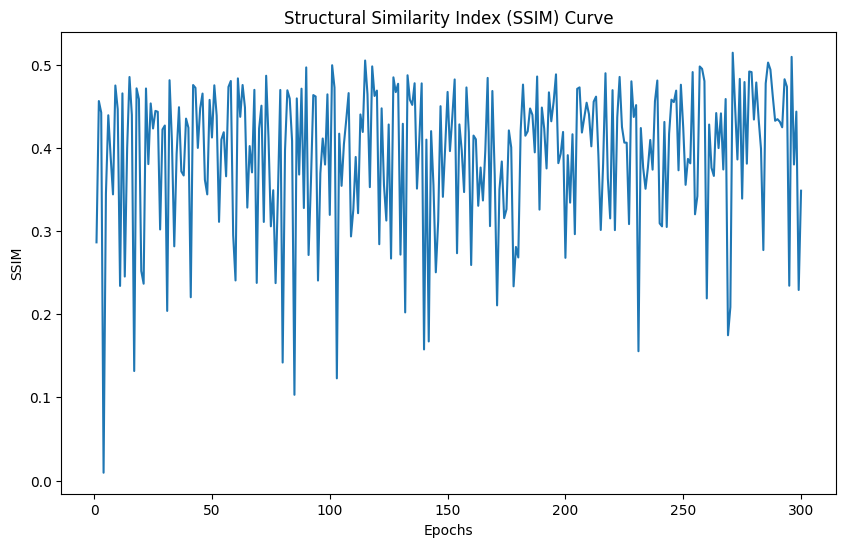

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(epoch_numbers, ssim_values)
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.title('Structural Similarity Index (SSIM) Curve')
plt.show()

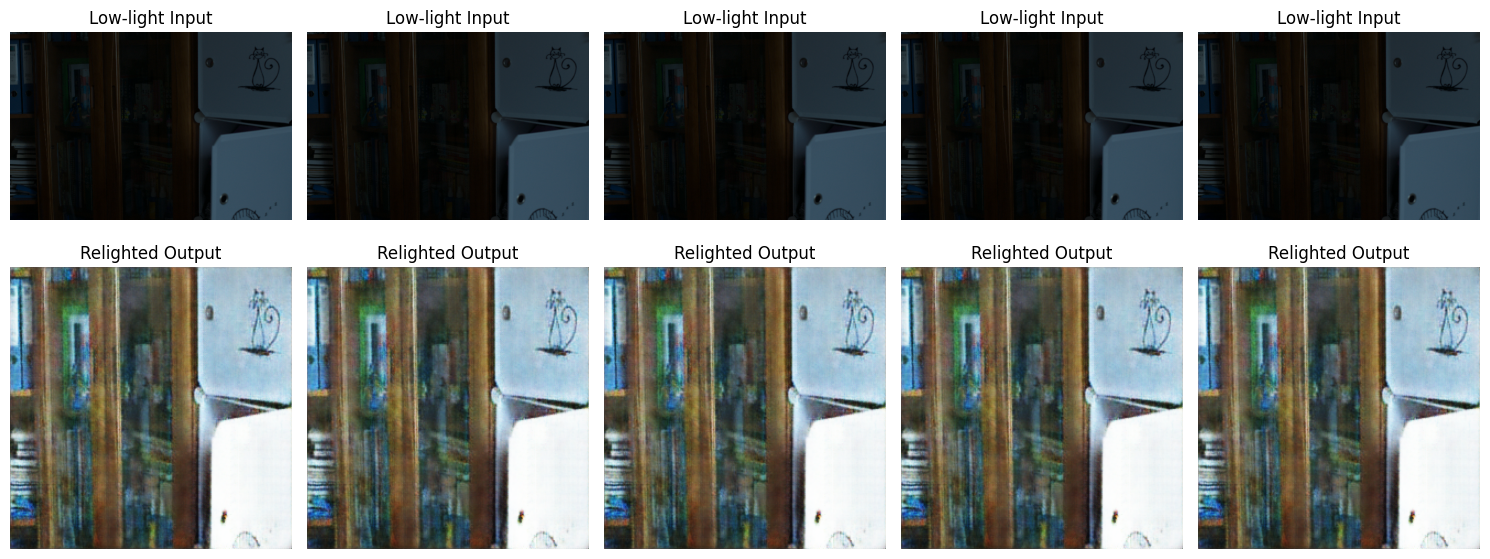

In [20]:
# Load the trained generator for inference
# Modify the path to load the appropriate saved model
generator.load_state_dict(torch.load(f'generator_epoch_{num_epochs}.pth'))
generator.eval()

# Transform for input image
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load and preprocess some sample low-light images
sample_low_light_images = [Image.open('/content/drive/MyDrive/lol_dataset/eval15/low/1.png') for i in range(5)]
sample_input_tensors = [transform(img).unsqueeze(0).to(device) for img in sample_low_light_images]

# Generate and display sample relighted images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, input_tensor in enumerate(sample_input_tensors):
    with torch.no_grad():
        relighted_image = generator(input_tensor)[0]

    relighted_image = relighted_image.permute(1, 2, 0).detach().cpu().numpy()
    relighted_image = (relighted_image * 0.5 + 0.5) * 255
    relighted_image = relighted_image.astype(np.uint8)

    axes[0, i].imshow(sample_low_light_images[i])
    axes[0, i].set_title('Low-light Input')
    axes[0, i].axis('off')

    axes[1, i].imshow(relighted_image)
    axes[1, i].set_title('Relighted Output')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/lol_dataset/relighted/relighted.png')
plt.show()